In [40]:
import torch #tensors and nns
from torch import nn, optim #neural nets and optimizers
from torch.utils.data import Dataset, DataLoader #utils to do batch processing of tensors
from torchvision import transforms #image transformations and mainpulations, mainly MATLAB functions rewritten in CPP
from PIL import Image #pillow for image loading
import numpy as np #lin alg
import scipy.ndimage #n dimensional imnage processing
from transformers import ViTModel #vision transformers
from tqdm import tqdm #progress bar packaging
import os #the os, for fs access to load the dataset
import glob #loading globals for fs access to load dataset
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn.functional as F

## Constants

In [41]:
train_image_paths = 'jhu_crowd_v2.0/train/images/'
train_annotations = 'jhu_crowd_v2.0/train/gt/'
val_image_paths = 'jhu_crowd_v2.0/val/images/'
val_annotations = 'jhu_crowd_v2.0/val/gt/'
test_image_paths = 'jhu_crowd_v2.0/test/images/'
test_annotations = 'jhu_crowd_v2.0/test/gt/'

transform = transforms.Compose([
    #fake low-res, dont know what actual res the cameras on trains are. downscale to 64x64 img
    transforms.Resize((64, 64)),
    transforms.Resize((224, 224)),     # vits want 224x224, cnns don't care
    transforms.ToTensor()
])




# Sample image, annotation

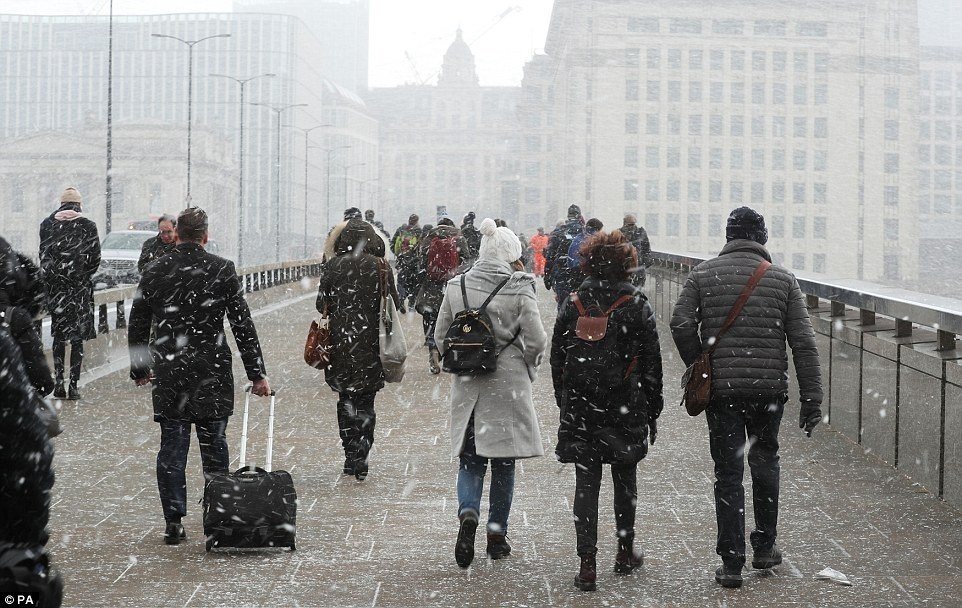

In [42]:
sample_img = Image.open('jhu_crowd_v2.0/train/images/0025.jpg')
sample_img

# What this means:
$[x_{head}, y_{head}, width(img), height(img), occlusion, blur]$ for each person in the image that was labeled.


In [43]:
pts = []
with open('jhu_crowd_v2.0/train/gt/0025.txt', 'r') as sample_annot :
    for line in sample_annot:
        x, y = float(line.strip().split()[0]), float(line.strip().split()[1])
        pts.append((x, y))


In [44]:
pts

[(166.0, 228.0),
 (414.0, 218.0),
 (541.0, 232.0),
 (353.0, 213.0),
 (629.0, 222.0),
 (497.0, 243.0),
 (468.0, 222.0),
 (448.0, 227.0),
 (737.0, 220.0),
 (188.0, 228.0),
 (72.0, 198.0),
 (371.0, 214.0),
 (362.0, 242.0),
 (606.0, 260.0),
 (74.0, 228.0),
 (597.0, 226.0),
 (576.0, 213.0)]

# Converting and loading the image

1. We apply the transformation defined earlier, taking into account the annotations (specifically the head positions, since those are the labels we actually care about). We then create a zero matrix of size 224x224 (the size of our upscaled image, post transformation).
2. For each annotated point at coords $(x, y)$: we create a dirac delta function approximation (https://en.wikipedia.org/wiki/Dirac_delta_function), or an impulse. Basically, at indices between 0 and 223, the value of $D_{ij} = 1$  if there is an annotation and 0 otherwise.
3. To smooth the region, and assign each head a "blob", or region of spatial context instead of a point in space, we apply a gaussian filter, and convolve it over the matrix $D$ we defined earlier. $$D'(x,y) = D(x,y)*G_\sigma(x,y)$$  assuming that $G(x,y) = \frac{1}{2\pi \sigma ^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$ Also, smooth regions are easier for NNs to learn from than convex regions, and this converts the task from a continous one to a discrete one. Note that this process converts the total mass of heads, since $\sum_i,jD'_{i,j}\simeq N$, where $N$ is the number of annotated heads in the original image.
3a. For an example, I have every transformation plotted out, since it is hard to visualize this mentally without an example
4. Finally, the image is converted to a PyTorch tensor, where it is "unsqueezed", or has a channel dimension attached to the front of it.


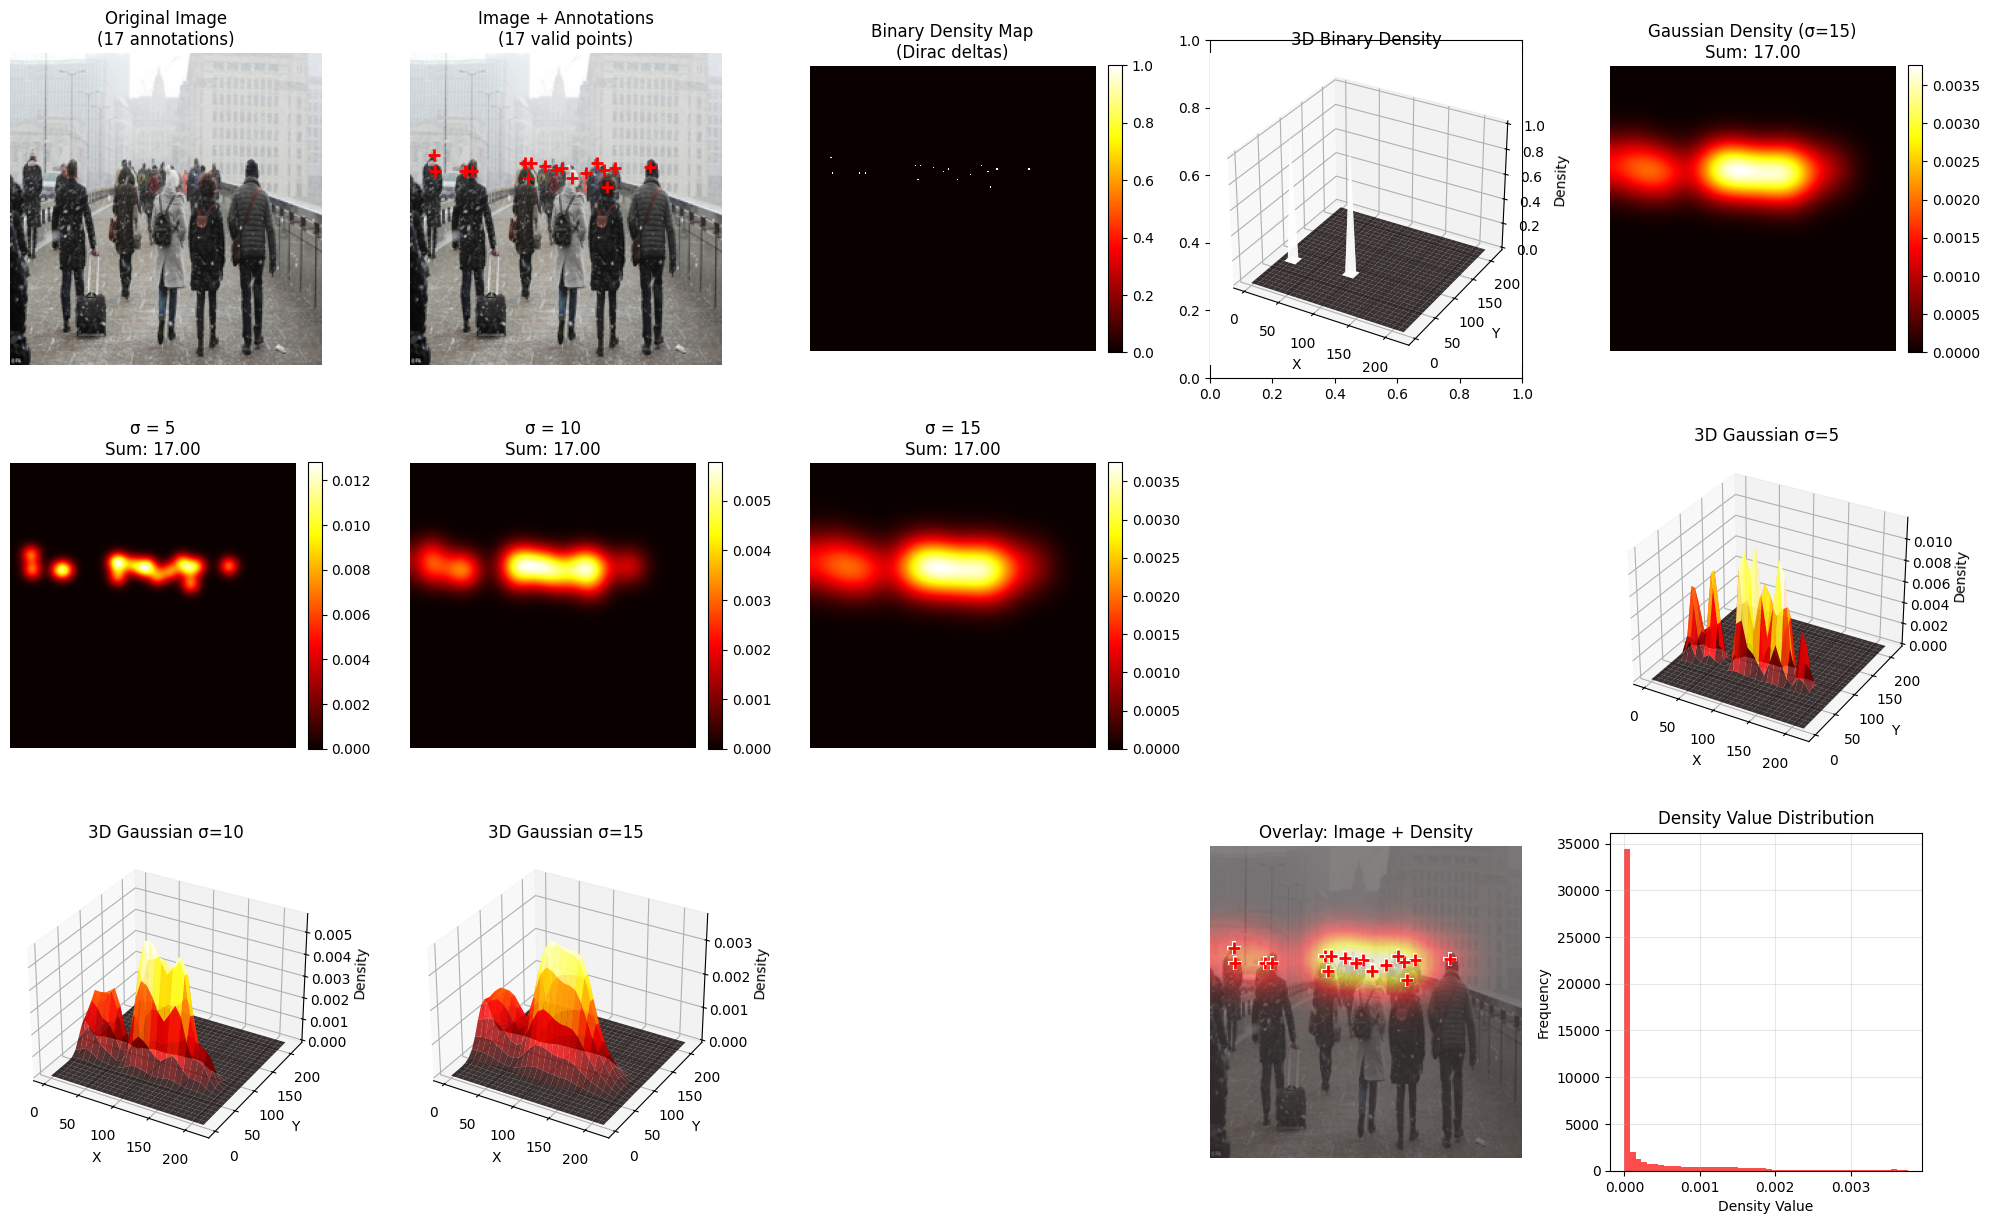

In [45]:
def visualize_density_transformations(image_path, annotations, transform, save_path=None):



    img = Image.open(image_path).convert('RGB')
    W_orig, H_orig = img.size
    img_resized = img.resize((224, 224))

    binary_density = np.zeros((224, 224), dtype=np.float32)
    valid_points = []

    for x, y in annotations:
        x_rescaled = x * 224 / W_orig
        y_rescaled = y * 224 / H_orig
        if 0 <= x_rescaled < 224 and 0 <= y_rescaled < 224:
            binary_density[int(y_rescaled), int(x_rescaled)] = 1
            valid_points.append((x_rescaled, y_rescaled))

    gaussian_density = scipy.ndimage.gaussian_filter(binary_density, sigma=15)

    sigma_values = [5, 10, 15]
    gaussian_variants = []
    for sigma in sigma_values:
        variant = scipy.ndimage.gaussian_filter(binary_density, sigma=sigma)
        gaussian_variants.append(variant)

    fig = plt.figure(figsize=(20, 16))

    plt.subplot(4, 5, 1)
    plt.imshow(img_resized)
    plt.title(f'Original Image\n({len(annotations)} annotations)', fontsize=12)
    plt.axis('off')

    plt.subplot(4, 5, 2)
    plt.imshow(img_resized)
    for x, y in valid_points:
        plt.plot(x, y, 'r+', markersize=8, markeredgewidth=2)
    plt.title(f'Image + Annotations\n({len(valid_points)} valid points)', fontsize=12)
    plt.axis('off')

    plt.subplot(4, 5, 3)
    plt.imshow(binary_density, cmap='hot', interpolation='nearest')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('Binary Density Map\n(Dirac deltas)', fontsize=12)
    plt.axis('off')

    plt.subplot(4, 5, 4)
    x_grid, y_grid = np.meshgrid(np.arange(0, 224, 8), np.arange(0, 224, 8))
    ax = fig.add_subplot(4, 5, 4, projection='3d')
    ax.plot_surface(x_grid, y_grid, binary_density[::8, ::8], cmap='hot', alpha=0.8)
    ax.set_title('3D Binary Density', fontsize=12)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Density')

    plt.subplot(4, 5, 5)
    plt.imshow(gaussian_density, cmap='hot', interpolation='bilinear')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f'Gaussian Density (σ=15)\nSum: {gaussian_density.sum():.2f}', fontsize=12)
    plt.axis('off')

    for i, (sigma, variant) in enumerate(zip(sigma_values, gaussian_variants)):
        plt.subplot(4, 5, 6 + i)
        plt.imshow(variant, cmap='hot', interpolation='bilinear')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(f'σ = {sigma}\nSum: {variant.sum():.2f}', fontsize=12)
        plt.axis('off')

    for i, (sigma, variant) in enumerate(zip(sigma_values, gaussian_variants)):
        ax = fig.add_subplot(4, 5, 10 + i, projection='3d')
        ax.plot_surface(x_grid, y_grid, variant[::8, ::8], cmap='hot', alpha=0.8)
        ax.set_title(f'3D Gaussian σ={sigma}', fontsize=12)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Density')

    plt.subplot(4, 5, 15)
    plt.hist(gaussian_density.flatten(), bins=50, alpha=0.7, color='red')
    plt.title('Density Value Distribution', fontsize=12)
    plt.xlabel('Density Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)




    plt.subplot(4,5,14)
    plt.imshow(img_resized, alpha=0.7)
    plt.imshow(gaussian_density, cmap='hot', alpha=0.5, interpolation='bilinear')
    for x, y in valid_points:
        plt.plot(x, y, 'w+', markersize=10, markeredgewidth=3)
        plt.plot(x, y, 'r+', markersize=8, markeredgewidth=2)
    plt.title('Overlay: Image + Density', fontsize=12)
    plt.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")

    plt.show()

    return binary_density, gaussian_density


binary_density, gaussian_density = visualize_density_transformations('jhu_crowd_v2.0/train/images/0025.jpg', transform = transform, annotations = pts)

# So, we do this process over the set of all train images, creating PyTorch DataLoaders. The training data, $X$, is the images themselves, and the labels, $y$, are the annotations, extracted from the text files.

In [46]:
def load_jhu_dataset(image_dir, gt_dir):
    annotations = []
    img_paths =  sorted(glob.glob(os.path.join(image_dir, '*.jpg')))

    for img_path in img_paths:
        img_num = img_path.split('images/')[1].strip('.jpg')
        gt_path = os.path.join(gt_dir, img_num + '.txt')
        pts = []
        with open(gt_path, 'r') as f:
            for line in f:
                x, y = float(line.strip().split()[0]), float(line.strip().split()[1])
                pts.append((int(x), int(y)))

        annotations.append(pts)
    return img_paths, annotations
class CrowdDataset(Dataset):
    def __init__(self, image_paths, annotations, transform):
        self.paths = image_paths
        self.annots = annotations  # list of head-point lists per image
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        img = self.transform(img)
        pts = self.annots[idx]
        density = np.zeros((224, 224), dtype=np.float32)
        for x, y in pts:
            if 0 <= x < 224 and 0 <= y < 224:
                density[int(y), int(x)] = 1
        density = scipy.ndimage.gaussian_filter(density, sigma=15)
        density = torch.from_numpy(density).unsqueeze(0)
        return img, density
i, a = load_jhu_dataset(train_image_paths, train_annotations)
tcds = CrowdDataset(i, a, transform=transform)
print(len(tcds))

2272


# Architecture:
Since we coerced this to a discrete task, we can use a Regressor to aim to predict heads, or a density map, even in "real-time". Google has a pretrained vision transformer that I've chosen to fine-tune for this, but it is also possible (but not recommended) to train a ViT in house. Currently, ViT (Vision Transformers) are straight up worse than CNNS, both cost and performance wise. Google's model here breaks an image into 16x16 pixel patches, normalizes it via LayerNorm (a method both for regularization and speedup, as well as common-sense practice), splits the sequence into heads, performs the classic attention calculation $A = softmax(\frac{QK^T}{\sqrt{d_k}})$. The original transformer architecture focuses on saliency, where attention scores can be visualized as a heat map. However, ViTs are usually trained in a self-supervised manner, not really a supervised-way. For example, in the original google ViT paper, a [CLS] token was added to create a token for CDAMs (Class Discriminant Attention Maps) to be able to map gradients with respect to the [CLS] token. [CLS] here, refers to classification, but crowd counting is inherently a regression task (predicting continuous output, in this case density maps). The naive way to address this, is to simply change the structure of the output after the transformer layers. Since the original architecture uses Softmax to output class probabilities, we can simply replace this with an MLP (Multi Layer Perceptron) with no activation function, or a ReLU(rectified linear unit) if we want to allow non-negative counts only (ReLU = x if x > 0  else 0, also has a really easy derivative, which makes it handy for NNs.). Switching the Loss Function is also really easy. Regression will normally use MSE or MAE, and we can simply use those as well. ViTs use fixed positional embeddings, which means that things are liable to break if input resolution changes from sequence to sequence. The best approach would be to model after Swin, and use relative positional embeddings, or to interpolate positional embeddings while fine-tuning on different resolutions. What I did was fine-tune google's ViT, and make a hybrid CNN/ViT architectecture to address both issues. This is realitstically the best performing approach if we want to still capture global context.







## Note on CNN vs ViT:

CNNs (Convolutional Neural Networks) rely on the mechanism of convolution to capture hierarchical features in images. They do not ever extract "concepts" or understanding from images, but are able to draw local features and spatial hierarchy from pixels and do not need nearly as much data.
ViTs on the other hand, suffer from the same issues as generalized Transformer models. Since ViTs are self-attentive by nature, they excel at capturing global context, and understanding which parts of a sequence are relevant, over time. They do very well in hybrid architectures, such as SwinTransformer https://arxiv.org/abs/2103.14030. However, they are very reliant on large datasets and need positional embeddings if pretrained, which could be an issue at very low resolutions. Also, they're just generally super expensive. Currently, CSRNet is the king for crowd counting, which is a CNN-based approach. https://www.nature.com/articles/s41598-025-90750-5

In [47]:

class ViTCountRegressor(nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model

        hidden_size = self.vit.config.hidden_size
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_size, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1)
        )

    def forward(self, x):
        vit_output = self.vit(x).last_hidden_state[:, 1:, :]
        batch_size = vit_output.shape[0]
        hidden_size = vit_output.shape[-1]
        feature_map = vit_output.transpose(1, 2).view(batch_size, hidden_size, 14, 14)
        density_map = self.decoder(feature_map)

        return density_map

In [48]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16()
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [51]:
def train_epoch(model, train_dl, val_dl, optimizer, criterion, n_epoch, device):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(n_epoch):
        model.train()
        epoch_train_loss = 0.0

        for imgs, dens in tqdm(train_dl, desc="Training"):

            imgs, dens = imgs.to(device), dens.to(device)

            if isinstance(model, CSRNet):
                dens = F.interpolate(dens, size=(28, 28), mode='bilinear', align_corners=False)

            pred = model(imgs)
            train_loss = criterion(pred, dens)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()

        mean_train_loss = epoch_train_loss / len(train_dl)
        train_losses.append(mean_train_loss)

        model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():
            for imgs, dens in tqdm(val_dl, desc="Validation"):
                imgs, dens = imgs.to(device), dens.to(device)

                if isinstance(model, CSRNet):
                    dens = F.interpolate(dens, size=(28, 28), mode='bilinear', align_corners=False)

                pred = model(imgs)
                val_loss = criterion(pred, dens)

                epoch_val_loss += val_loss.item()

        mean_val_loss = epoch_val_loss / len(val_dl)
        val_losses.append(mean_val_loss)

        print(f'epoch: {epoch+1}/{n_epoch}, train_loss: {mean_train_loss:.6f}, val_loss: {mean_val_loss:.6f}')

        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            print(f'New best val loss: {best_val_loss:.6f}')

    return train_losses, val_losses


def mean_absolute_error(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    return mae


def evaluate(model, test_dl, device):
    model.eval()
    test_mae = 0.0

    with torch.no_grad():
        for imgs, dens in tqdm(test_dl, desc="Evaluating"):
            imgs, dens = imgs.to(device), dens.to(device)

            if isinstance(model, CSRNet):
                dens = F.interpolate(dens, size=(28, 28), mode='bilinear', align_corners=False)

            pred = model(imgs)

            pred_np = pred.cpu().numpy()
            dens_np = dens.cpu().numpy()

            test_mae += mean_absolute_error(pred_np, dens_np)

    return test_mae / len(test_dl)

In [52]:

def head_to_head(mod1, mod2, train_dl, val_dl, test_dl, optimizer_m1, optimizer_m2, criterion, n_epoch, device):
    train_epoch(mod1, train_dl, val_dl, optimizer_m1, criterion, n_epoch, device)
    train_epoch(mod2, train_dl, val_dl, optimizer_m2, criterion, n_epoch, device)
    mod_1_mae = evaluate(mod1, test_dl, device)
    mod_2_mae = evaluate(mod2, test_dl, device)
    winner = mod1 if mod_1_mae < mod_2_mae else mod2
    return winner


def create_dl(paths, annot, split, bs):
    path, annot = load_jhu_dataset(paths, annot)
    ds = CrowdDataset(path, annot, transform)
    dl = DataLoader(ds, batch_size=bs, shuffle=split=='train', num_workers=0)
    return dl

if __name__ == "__main__":
    train_dl = create_dl(train_image_paths, train_annotations, 'train', 32)
    val_dl = create_dl(val_image_paths, val_annotations, 'val', 32)
    test_dl = create_dl(test_image_paths, test_annotations, 'test', 32)



    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit_model = ViTCountRegressor(ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')).to(device)
    cnn_model = CSRNet().to(device)
    vit_optimizer = optim.AdamW(vit_model.parameters(), lr=1e-4)
    cnn_optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()
    experiment = head_to_head(vit_model, cnn_model, train_dl, val_dl, test_dl, vit_optimizer, cnn_optimizer, criterion,
                              5, device)
    print(experiment)


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


epoch: 1/5, train_loss: 0.001048, val_loss: 0.000003
New best val loss: 0.000003


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


epoch: 2/5, train_loss: 0.000002, val_loss: 0.000001
New best val loss: 0.000001


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


epoch: 3/5, train_loss: 0.000001, val_loss: 0.000001
New best val loss: 0.000001


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


epoch: 4/5, train_loss: 0.000001, val_loss: 0.000001
New best val loss: 0.000001


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


epoch: 5/5, train_loss: 0.000001, val_loss: 0.000001
New best val loss: 0.000001


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


epoch: 1/5, train_loss: 0.000001, val_loss: 0.000001
New best val loss: 0.000001


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


epoch: 2/5, train_loss: 0.000001, val_loss: 0.000001


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


epoch: 3/5, train_loss: 0.000001, val_loss: 0.000001


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


epoch: 4/5, train_loss: 0.000001, val_loss: 0.000001


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


epoch: 5/5, train_loss: 0.000001, val_loss: 0.000001


Evaluating: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s]

ViTCountRegressor(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act

# why MAE for test over MSE? is it safe to use that considering we used MSE as the objective function?

1. MAE is more "interpretable", since it corresponds to actual counting error. MAE of 5, for example, means we are off by about 5 people on average. MSE of 5 does not give the same intuition.
2. MAE on density maps gives a way to measure the movement on average absolute difference.
3. MAE is less sensitive to outliers. Think about the graph of x^2 and abs(x), and how a change to the input impacts the output.
4. Note also that the two metrics take in the same inputs $\hat{y}, y$, and are highly correlated. This encourages the model to minimize the MAE while minimizing MSE.